In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import time

import dataset
import myModels
import Metrics
import LossFn

plt.style.use('science')
plt.rcParams['text.usetex'] = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\asus\.conda\envs\myTorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\asus\.conda\envs\myTorch_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
params = {
    'paths': os.path.abspath(os.path.join(os.getcwd(),'..')) + '/Datas/Thermal/',
    'inputs_FileName': ['Strains-50-1.xlsx','Strains-50-2.xlsx','Strains-100-1.xlsx','Strains-100-2.xlsx','Strains-120-1.xlsx'],
    'outputs_FileName': ['Loads-50-1.xlsx','Loads-50-2.xlsx','Loads-100-1.xlsx','Loads-100-2.xlsx','Loads-120-1.xlsx'],
    'SampleStride': [1,1,10,10,5],
    'seq_len': 100,
    'input_size': 14,
    'output_size': 6,
    'state':True,
    'Mask':True,
    'Robust_loss':False,
    'Noise_level': 0.0,
    'Noise_type':'Gaussion',
    'batch_size': 32,
    'lstm_layers': [50,50],
    'TCN_layers':[25, 50, 50],
    'kernel_size':3,
    'dropout':0.1,
    'Epoches': 1500,
    'lr':0.001,
    'dis_interval':100,
    'plot_loss':True,
    'device':device,

}


In [3]:
Data_set = dataset.MyDataset(params)
test_size = int(len(Data_set)*0.1)
train_set, test_set = torch.utils.data.random_split(Data_set, [len(Data_set) - test_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, shuffle=True)

Train Epoch: 0, loss: 1297.247294
--------------------------------------------------------
Train Epoch: 100, loss: 4.560786
--------------------------------------------------------
Train Epoch: 200, loss: 4.036427
--------------------------------------------------------
Train Epoch: 300, loss: 3.565003
--------------------------------------------------------
Train Epoch: 400, loss: 2.411845
--------------------------------------------------------
Train Epoch: 500, loss: 3.491292
--------------------------------------------------------
Train Epoch: 600, loss: 4.863580
--------------------------------------------------------
Train Epoch: 700, loss: 0.959829
--------------------------------------------------------
Train Epoch: 800, loss: 1.183085
--------------------------------------------------------
Train Epoch: 900, loss: 1.584390
--------------------------------------------------------
Train Epoch: 1000, loss: 1.384471
--------------------------------------------------------
Train Ep

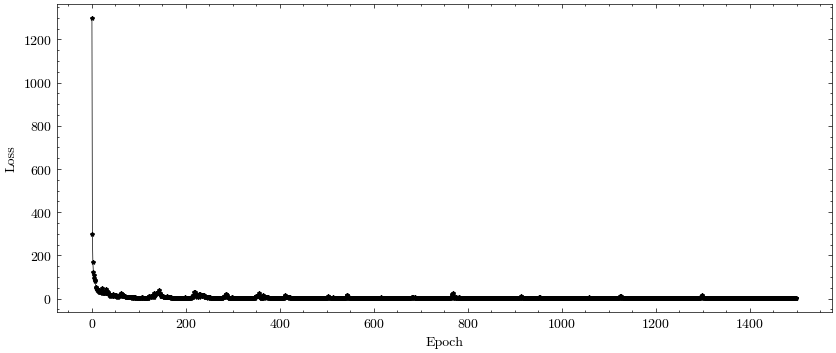

In [4]:
models = myModels.LSTM_TCN(params).to(device)
if params['Robust_loss']:
    loss_fn = LossFn.UncertaintyLoss(params)
    all_parameters = list(models.parameters()) + list(loss_fn.parameters())
else:
    loss_fn = nn.MSELoss()
    all_parameters = models.parameters()
    
optimizer = optim.Adam(all_parameters, params['lr'])
losses = models._Train(optimizer,train_loader,loss_fn)

In [8]:
# test models in the whole testSet
models = torch.load('LSTM_TCN-1.pt')
for _,data in enumerate(test_loader):
    x = data[0].clone().detach().requires_grad_(True).float().to(params['device'])
    Truths = data[1].clone().detach().requires_grad_(True).float().to(params['device'])

RMSEs = []
MAPEs = []
R2s = []
times = []
for i in range(100):
    for _,data in enumerate(test_loader):
        x = data[0].clone().detach().requires_grad_(True).float().to(params['device'])
        Truths = data[1].clone().detach().requires_grad_(True).float().to(params['device'])
    since = time.time()    
    Preds = myModels.predict(models,x,params,mask=True)
    time_elapsed = time.time() - since
    print ('Computing Times: {}s'.format(time_elapsed))
    times.append(time_elapsed)
    print ('RMSE of Test Set: {}'.format(Metrics.rmse(Truths,Preds)))
    RMSEs.append(Metrics.rmse(Truths,Preds))
    print ('MAPE of Test Set: {}'.format(Metrics.mape(Truths,Preds)))
    MAPEs.append(Metrics.mape(Truths,Preds))
    print ('R2 of Test Set: {}'.format(Metrics.r2_score(Truths,Preds)))
    R2s.append((Metrics.r2_score(Truths,Preds)-0.99)*100)

Computing Times: 0.015505075454711914s
RMSE of Test Set: 0.7435376048088074
MAPE of Test Set: 0.7895329035818577
R2 of Test Set: 0.9995018078479916
Computing Times: 0.010504961013793945s
RMSE of Test Set: 0.5268579721450806
MAPE of Test Set: 0.7290443405508995
R2 of Test Set: 0.9996077407558914
Computing Times: 0.008090496063232422s
RMSE of Test Set: 0.9310724139213562
MAPE of Test Set: 0.8554269559681416
R2 of Test Set: 0.9993916262174025
Computing Times: 0.008055925369262695s
RMSE of Test Set: 0.7469456791877747
MAPE of Test Set: 0.6877786014229059
R2 of Test Set: 0.9995410440897103
Computing Times: 0.008173465728759766s
RMSE of Test Set: 0.559788703918457
MAPE of Test Set: 0.613487372174859
R2 of Test Set: 0.9997635407780763
Computing Times: 0.009502172470092773s
RMSE of Test Set: 0.6854631304740906
MAPE of Test Set: 0.559147959575057
R2 of Test Set: 0.9996873994823545
Computing Times: 0.010503292083740234s
RMSE of Test Set: 0.6399434804916382
MAPE of Test Set: 0.681553315371275
R2 

Computing Times: 0.005505800247192383s
RMSE of Test Set: 0.5185010433197021
MAPE of Test Set: 0.6460960488766432
R2 of Test Set: 0.999682266759919
Computing Times: 0.0055065155029296875s
RMSE of Test Set: 0.6320012211799622
MAPE of Test Set: 0.721215782687068
R2 of Test Set: 0.9996413618209772
Computing Times: 0.005505084991455078s
RMSE of Test Set: 0.6818400025367737
MAPE of Test Set: 0.8329232223331928
R2 of Test Set: 0.9994495363789611
Computing Times: 0.00599980354309082s
RMSE of Test Set: 0.6079801321029663
MAPE of Test Set: 0.6818388123065233
R2 of Test Set: 0.9997050772071816
Computing Times: 0.0060002803802490234s
RMSE of Test Set: 0.5309637188911438
MAPE of Test Set: 0.706761796027422
R2 of Test Set: 0.9997292293410283
Computing Times: 0.005507946014404297s
RMSE of Test Set: 0.582169234752655
MAPE of Test Set: 0.7149232551455498
R2 of Test Set: 0.9996404860576149
Computing Times: 0.0055048465728759766s
RMSE of Test Set: 0.43401092290878296
MAPE of Test Set: 0.6162349600344896


times = torch.save(times,'times.pt')
RMSEs = torch.save(RMSEs,'RMSEs.pt')
MAPEs = torch.save(MAPEs,'MAPEs.pt')
R2s = torch.save(R2s,'R2s.pt')

In [9]:
models

LSTM_TCN(
  (lstms): deepLSTM(
    (lstms): ModuleList(
      (0): LSTM(15, 50, batch_first=True, bidirectional=True)
      (1): LSTM(100, 50, batch_first=True, bidirectional=True)
      (2): LSTM(100, 15, batch_first=True)
    )
  )
  (tcn): TCN(
    (tcn): TemporalConvNet(
      (network): Sequential(
        (0): TemporalBlock(
          (conv1): Conv1d(15, 25, kernel_size=(3,), stride=(1,), padding=(1,))
          (relu1): ReLU()
          (dropout1): Dropout(p=0.1, inplace=False)
          (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(1,))
          (relu2): ReLU()
          (dropout2): Dropout(p=0.1, inplace=False)
          (net): Sequential(
            (0): Conv1d(15, 25, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): ReLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=(1,))
            (4): ReLU()
            (5): Dropout(p=0.1, inplace=False)
          )
          (downs

In [28]:
max_time = np.max(times)
median_time = np.median(times)
min_time = np.min(times)

max_time

0.014008522033691406

In [48]:
np.max(RMSEs)

1.4286863

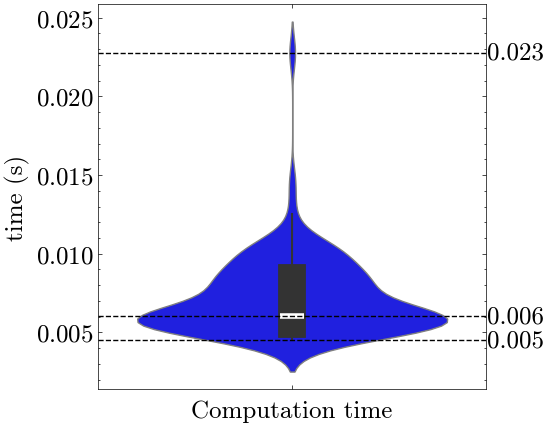

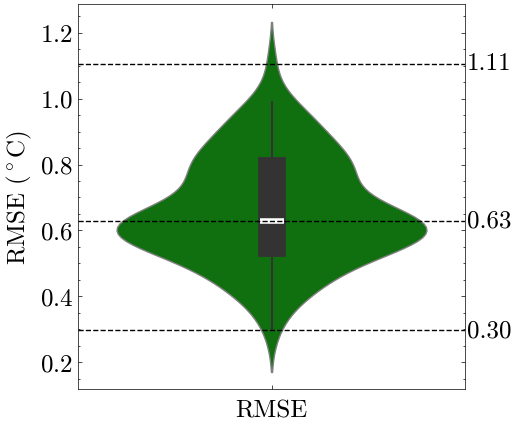

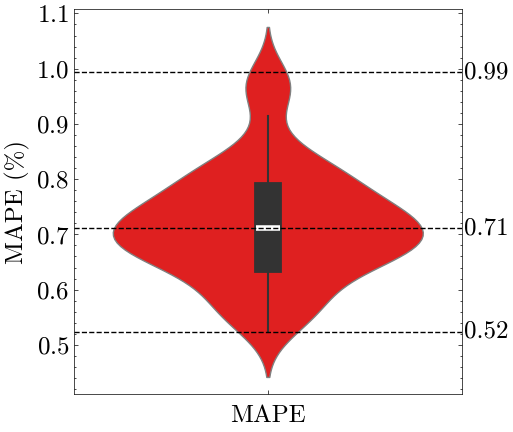

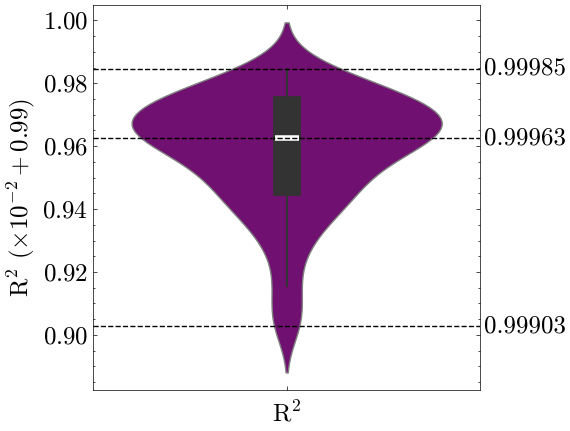

In [82]:

# 设置图形的大小
plt.rcParams.update({'font.size': 18})
# 绘制时间数据的小提琴图
plt.figure(figsize=(5, 5))
sns.violinplot(y=times, inner='box', color='blue', linewidth=1,edgecolor='gray', width=0.8,inner_kws=dict(box_width=20, whis_width=1.5, color=".2"))
plt.axhline(y=np.max(times), color='k', linestyle='--', label='Max')
plt.axhline(y=np.median(times), color='k', linestyle='--', label='Median')
plt.axhline(y=np.min(times), color='k', linestyle='--', label='Min')

plt.text(1.15, np.max(times), f'{np.max(times):.3f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.15, np.median(times), f'{np.median(times):.3f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.15, np.min(times), f'{np.min(times):.3f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())

plt.xlabel('Computation time')
plt.ylabel('time (s)')

# 绘制 RMSE 数据的小提琴图
plt.figure(figsize=(5, 5))
sns.violinplot(y=RMSEs, inner='box', color='green', linewidth=1, edgecolor='gray', width=0.8,inner_kws=dict(box_width=20, whis_width=1.5, color=".2"))
plt.axhline(y=np.max(RMSEs), color='k', linestyle='--', label='Max')
plt.axhline(y=np.median(RMSEs), color='k', linestyle='--', label='Median')
plt.axhline(y=np.min(RMSEs), color='k', linestyle='--', label='Min')
plt.text(1.12, np.max(RMSEs), f'{np.max(RMSEs):.2f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.12, np.median(RMSEs), f'{np.median(RMSEs):.2f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.12, np.min(RMSEs), f'{np.min(RMSEs):.2f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())

plt.xlabel('RMSE')
plt.ylabel('RMSE ($^\circ\mathrm{C}$)')

# 绘制 MAPE 数据的小提琴图
plt.figure(figsize=(5, 5))
sns.violinplot(y=MAPEs, inner='box', color='red', linewidth=1, edgecolor='gray', width=0.8,inner_kws=dict(box_width=20, whis_width=1.5, color=".2"))
plt.axhline(y=np.max(MAPEs), color='k', linestyle='--', label='Max')
plt.axhline(y=np.median(MAPEs), color='k', linestyle='--', label='Median')
plt.axhline(y=np.min(MAPEs), color='k', linestyle='--', label='Min')
plt.text(1.12, np.max(MAPEs), f'{np.max(MAPEs):.2f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.12, np.median(MAPEs), f'{np.median(MAPEs):.2f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.12, np.min(MAPEs), f'{np.min(MAPEs):.2f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.xlabel('MAPE')
plt.ylabel('MAPE (%)')

# 绘制 R2 数据的小提琴图
plt.figure(figsize=(5, 5))
sns.violinplot(y=R2s, inner='box', color='purple', linewidth=1, edgecolor='gray', width=0.8,inner_kws=dict(box_width=20, whis_width=1.5, color=".2"))
plt.axhline(y=np.max(R2s), color='k', linestyle='--', label='Max')
plt.axhline(y=np.median(R2s), color='k', linestyle='--', label='Median')
plt.axhline(y=np.min(R2s), color='k', linestyle='--', label='Min')
plt.text(1.22, np.max(R2s), f'{np.max(R2s)/100+0.99:.5f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.22, np.median(R2s), f'{np.median(R2s)/100+0.99:.5f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.text(1.22, np.min(R2s), f'{np.min(R2s)/100+0.99:.5f}', color='k', ha='right', va='center', transform=plt.gca().get_yaxis_transform())
plt.xlabel('R$^2$')
plt.ylabel('R$^2$ ($\\times10^{-2}+0.99$)')

# 显示图形
plt.show()


Text(0.5, 0, 'Epochs')

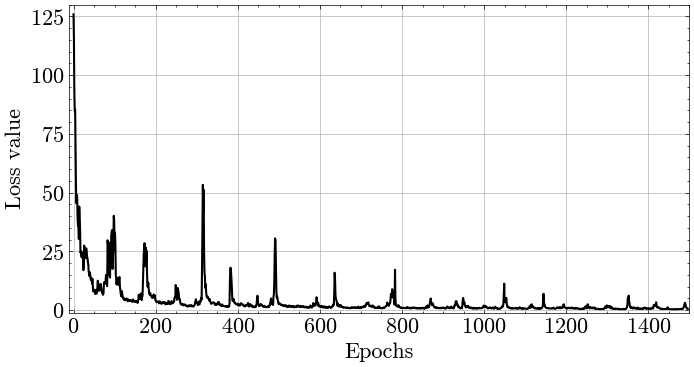

In [34]:
losses = torch.load('LSTM_TCN-1-losses.pt')
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,4))
plt.plot(range(len(losses[3:])),losses[3:],color='black',linewidth=1.5)
plt.xlim(-10,1500)
plt.ylim(-1,130)
plt.grid(True)
plt.ylabel('Loss value')
plt.xlabel('Epochs')